## Primate brain mass

### The question

<div>
<img src="attachment:glia.jpg" width='50%' title=""/>
</div>


In this dataset scientists measured the brain mass (in grams) and the ratio of glia cells to neurons of 18 primate species including humans. They wanted to examine the relationship between brain mass and the ratio of glia cells to neurons. 

If there is no relationship between brain mass and glia-neuron ratio, then a plot of brain mass against glia-neuron ratio would exhibit a flat line. A line, that is, with a slope of zero as sketched in the left panel if the figure below. Conversely, if there is a relationship between them such a plot would exhibit either a rising or a falling line. That is, a line with non-zero slope as sketched in the middle and right panels in the figure below.

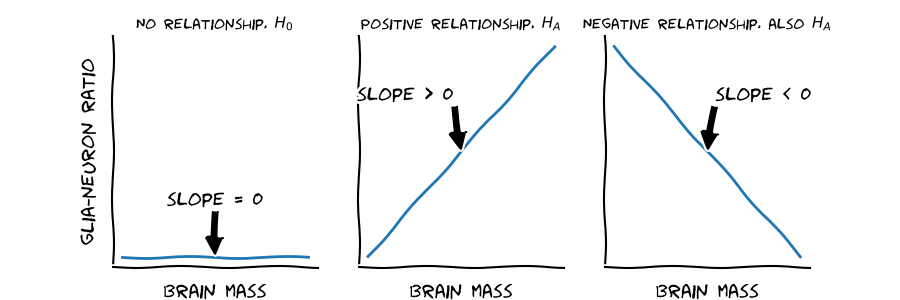

Remember, the null hypothesis is the hypothesis of no difference or no change. So we can write down our null and alternative hypotheses:

$$
H_0: \mathrm{slope} = 0 \newline
H_A: \mathrm{slope} \ne 0
$$ 

### Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.formula.api import ols

warnings.filterwarnings("ignore")

### Load and print the data

First we read in the dataset and print it to see how it looks and what the variable names, types and values are.

In [2]:
brain = pd.read_csv('../Datasets/brain_mass.csv')
brain

,species,mass,ratio
0,Saguinus oedipus,10.0,0.46
1,Leontopithecus rosalia,12.2,0.60
2,Aotus trivirgatus,13.2,0.63
3,Saimiri boliviensis,24.1,0.51
4,Pithecia pithecia,30.0,0.64
5,Alouatta caraya,55.8,1.12
6,Cercopithecus kandti,71.6,1.15
7,Colobus angolensis,74.4,1.20
8,Trachypithecus francoisi,91.2,1.14
9,Macaca maura,92.6,0.84


Variable names are "species", "mass" and "ratio". The variable "species" is categorical, but each row is a unique species of primate so there is nothing we can do with it from a statistical point of view. It can therefore be ignored. Both "mass" and "ratio" are continuous numerical variables. The variable "mass" is the average brain mass in grams of each species. It varies over quite a wide range - over several orders of magnitude in fact. This will cause problems when fitting a linear model as we will see. The variable "ratio" is the ratio of glia cells to neurons.

There's not really response and explanatory variables in this dataset. A change in one variable cannot be said to explain, or cause a change in, the other variable. So we can chose to write the model either way. Let's chose `mass` as the explanatory variable and `ratio` as the response.

As both variables are numerical we should plot them as a scatter plot with Seaborn's lmplot. This will also give us a regression line of the model `ratio ~ mass`.

### Plot the data

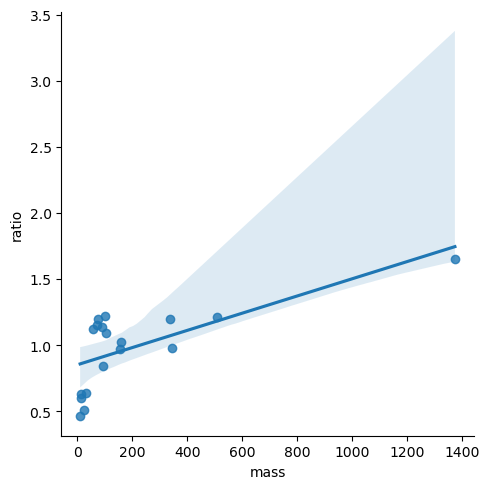

In [3]:
sns.lmplot(x='mass', y='ratio', data=brain);

This plot does not look good. The human data point stands out from the rest of the data because of it's large mass of 1.4 kg. It exerts a strong influence on the model fit. The 95% CI shown by the light blue band also looks wrong. What this tells us is that there is not a **linear** relationship between brain mass and glia-neuron ratio. Our linear model `ratio ~ mass` is wrong, and we should look for a more appropriate model.

Given that "mass" varies over several orders (human brains are 140 times more massive than cotton-top tamarin (*Saguinus oedipus*) brains), it makes sense test if it is normally distributed. For that we use the Shapiro-Wilks test.


In [4]:
from scipy.stats import shapiro

shapiro(brain['mass'])

ShapiroResult(statistic=0.5759567763613072, pvalue=3.945284431974003e-06)

We see that the *p*=value is less than 0.05 so we can conclude that "mass" is not normally distributed.

Let's log-transform mass to see if that makes it normal. Remember that logs make numbers that are very far apart much closer to each other. The table below shows that when numbers that vary over many orders of magnitude are logged they are transformed onto a linear scale

x | log<sub>10</sub>(x)
:--- | :---:
1 | 0
10 | 1
100 | 2
1000 | 3

So let's add another column to our dataframe that is the log of brain mass. We use the numpy function `np.log` to do this. Note that this does log to the base e (the natural log). You can also use `np.log10` which takes logs base 10. It makes no difference which one you use.

In [5]:
brain['logmass'] = np.log(brain['mass'])
brain


,species,mass,ratio,logmass
0,Saguinus oedipus,10.0,0.46,2.302585
1,Leontopithecus rosalia,12.2,0.60,2.501436
2,Aotus trivirgatus,13.2,0.63,2.580217
3,Saimiri boliviensis,24.1,0.51,3.182212
4,Pithecia pithecia,30.0,0.64,3.401197
5,Alouatta caraya,55.8,1.12,4.021774
6,Cercopithecus kandti,71.6,1.15,4.271095
7,Colobus angolensis,74.4,1.20,4.309456
8,Trachypithecus francoisi,91.2,1.14,4.513055
9,Macaca maura,92.6,0.84,4.528289


And now we check that "logmass" is normally distributed:

In [6]:
shapiro(brain['logmass'])

ShapiroResult(statistic=0.9673996688633795, pvalue=0.7476176389608516)

*p* = 0.75 so we can conclude that it is and carry on with the analysis.

Let's plot log-brain mass against glia-neuron ratio.

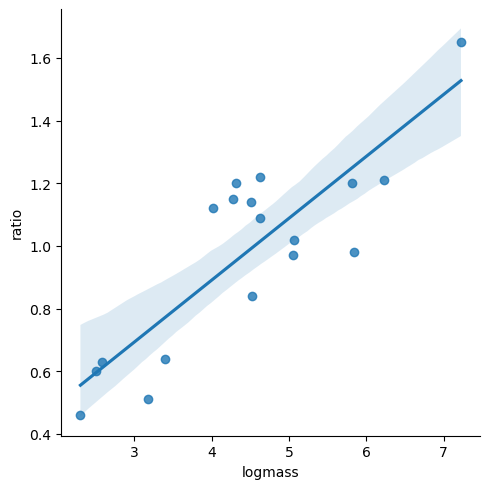

In [7]:
sns.lmplot(x='logmass', y='ratio', data=brain);

That looks much better. So our linear model is 

    ratio ~ logmass

That is, the ratio of glia cells to neurons is linearly related to the log of brain mass.

### Code and fit the model

In [8]:
formula = 'ratio ~ logmass'
fit = ols(formula, brain).fit()
fit.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1005,0.142,0.709,0.488,-0.200,0.401
logmass,0.1975,0.031,6.459,0.000,0.133,0.262


### Interpret the summary of the model fit

The intercept is not significantly different from zero as its *p*-value is 0.49 and its 95% CI is [-0.2, 0.4] contains zero. The slope is significantly different from zero as expected from the scatter plot. It's *p*-value is less than 0.001 and its 95% CI is [0.13, 0.26].

The formula that relates glia-neuron ratio to brain mass is therefore

$$
\mathrm{glia\ to\ neuron\ ratio} = 0.2 \ln(\mathrm
{brain\ mass})
$$

### Report the outcome of the test

There is a statistically significant linear relationship between the glia-neuron ratio and the log of brain mass in primates with a proportionality constant of 0.20 (95% CI: (0.13, 0.26), *n* = 18, *t* = 6.5, *p* < 0.001).